<a href="https://colab.research.google.com/github/liv20/Caltech-CS155-2022/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

import scipy

train_file = 'https://raw.githubusercontent.com/derekqin8/Caltech-CS155-2022/main/mps/CS155_mp1/data/LOANS_TRAIN.csv'
test_file = 'https://raw.githubusercontent.com/derekqin8/Caltech-CS155-2022/main/mps/CS155_mp1/data/LOANS_TEST.csv'

In [2]:
df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
df.head()

,id,loan_amnt,term_(months),int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,title,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status
0,0,5000,36,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,credit_card,Computer,860xx,AZ,27.65,Jan-1985,3,0,13648,83.7%,9,f,Individual,NaN,0.0,Fully Paid
1,1,2500,60,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,car,bike,309xx,GA,1.00,Apr-1999,3,0,1687,9.4%,4,f,Individual,NaN,0.0,Charged Off
2,2,2400,36,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,small_business,real estate business,606xx,IL,8.72,Nov-2001,2,0,2956,98.5%,10,f,Individual,NaN,0.0,Fully Paid
3,3,10000,36,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,other,personel,917xx,CA,20.00,Feb-1996,10,0,5598,21%,37,f,Individual,NaN,0.0,Fully Paid
4,4,3000,60,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,other,Personal,972xx,OR,17.94,Jan-1996,15,0,27783,53.9%,38,f,Individual,NaN,0.0,Fully Paid


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197250 entries, 0 to 197249
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    197250 non-null  int64  
 1   loan_amnt             197250 non-null  int64  
 2   term_(months)         197250 non-null  int64  
 3   int_rate              197250 non-null  object 
 4   installment           197250 non-null  float64
 5   grade                 197250 non-null  object 
 6   sub_grade             197250 non-null  object 
 7   emp_title             184917 non-null  object 
 8   emp_length            189334 non-null  object 
 9   home_ownership        197250 non-null  object 
 10  annual_inc            197250 non-null  float64
 11  verification_status   197250 non-null  object 
 12  issue_d               197250 non-null  object 
 13  purpose               197250 non-null  object 
 14  title                 197232 non-null  object 
 15  

In [4]:
dropped_features = ['addr_state', 'application_type', 'emp_title', 'grade',
                    'title', 'zip_code', 'mort_acc']
# drop unneeded features and id on train data
df.drop(dropped_features + ['id'], axis=1, inplace=True)
# drop unneeded features on test data
ids = test_df['id']
test_df.drop(dropped_features + ['id'], axis=1, inplace=True)

df.head()

,loan_amnt,term_(months),int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,pub_rec_bankruptcies,loan_status
0,5000,36,10.65%,162.87,B2,10+ years,RENT,24000.0,Verified,Dec-2011,credit_card,27.65,Jan-1985,3,0,13648,83.7%,9,f,0.0,Fully Paid
1,2500,60,15.27%,59.83,C4,< 1 year,RENT,30000.0,Source Verified,Dec-2011,car,1.00,Apr-1999,3,0,1687,9.4%,4,f,0.0,Charged Off
2,2400,36,15.96%,84.33,C5,10+ years,RENT,12252.0,Not Verified,Dec-2011,small_business,8.72,Nov-2001,2,0,2956,98.5%,10,f,0.0,Fully Paid
3,10000,36,13.49%,339.31,C1,10+ years,RENT,49200.0,Source Verified,Dec-2011,other,20.00,Feb-1996,10,0,5598,21%,37,f,0.0,Fully Paid
4,3000,60,12.69%,67.79,B5,1 year,RENT,80000.0,Source Verified,Dec-2011,other,17.94,Jan-1996,15,0,27783,53.9%,38,f,0.0,Fully Paid


In [5]:
df['days_from_earliest_cr'] = (pd.to_datetime(df['issue_d']) - pd.to_datetime(df['earliest_cr_line'])).map(lambda x: x.days)
df.drop(['issue_d', 'earliest_cr_line'], axis=1, inplace=True)
df['int_rate'] = df['int_rate'].str[:-1].apply(float)
df['revol_util'] = df['revol_util'].str[:-1].apply(float)

test_df['days_from_earliest_cr'] = (pd.to_datetime(test_df['issue_d']) - \
                                    pd.to_datetime(test_df['earliest_cr_line'])).map(lambda x: x.days)
test_df.drop(['issue_d', 'earliest_cr_line'], axis=1, inplace=True)
test_df['int_rate'] = test_df['int_rate'].str[:-1].apply(float)
test_df['revol_util'] = test_df['revol_util'].str[:-1].apply(float)

In [6]:
num_features = ['annual_inc', 'installment', 'int_rate',
                'days_from_earliest_cr', 'loan_amnt', 'open_acc',
                'revol_util', 'dti', 'days_from_earliest_cr', 'revol_bal',
                'total_acc'
                ]

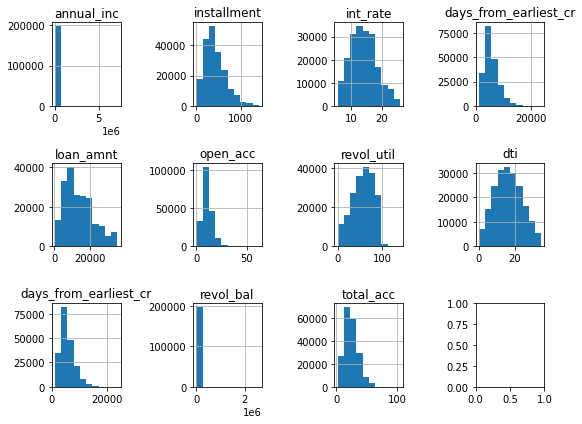

In [7]:
fig, ax = plt.subplots(3, 4)

m = 0
for num_feature in num_features:
  ax[m // 4, m % 4].set_title(num_feature)
  df[num_feature].hist(ax=ax[m // 4, m % 4], figsize=(8, 6))
  m += 1
plt.tight_layout()

In [8]:
def box_cox(data, test_data, col_name):
  col_data = np.array(data[col_name]) + 1
  column_data_clean = col_data[~np.isnan(col_data)]
  l, opt_lambda = scipy.stats.boxcox(column_data_clean)

  data[col_name] = scipy.stats.boxcox(col_data, lmbda=opt_lambda)

  test_col_data = test_data[col_name] + 1
  test_data[col_name] = scipy.stats.boxcox(test_col_data, lmbda=opt_lambda)

In [9]:
for num_feature in num_features:
  box_cox(df, test_df, num_feature)

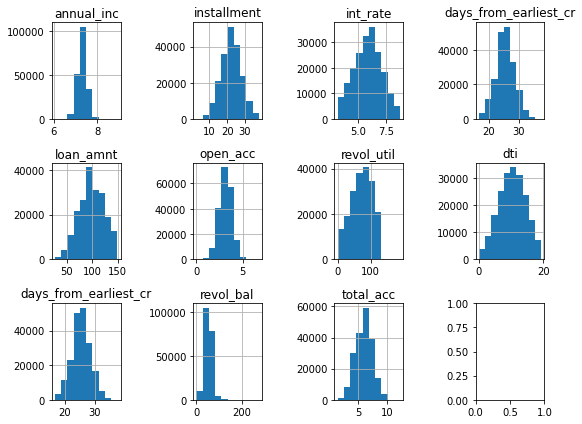

In [10]:
fig, ax = plt.subplots(3, 4)

m = 0
for num_feature in num_features:
  ax[m // 4, m % 4].set_title(num_feature)
  df[num_feature].hist(ax=ax[m // 4, m % 4], figsize=(8, 6))
  m += 1
plt.tight_layout()

# Categorical

In [11]:
df['initial_list_status'] = (df['initial_list_status'] == 'f')
df['term_(months)'] = df['term_(months)'] == 36
# df['pub_recs'] = (df['pub_rec'] > 0) | (df['pub_rec_bankruptcies'] > 0)
df['bankruptcies_binarized'] = df['pub_rec_bankruptcies'] > 0
df['pub_rec_binarized'] = df['pub_rec'] > 0
df.drop(['pub_rec', 'pub_rec_bankruptcies'], axis=1, inplace=True)

test_df['initial_list_status'] = (test_df['initial_list_status'] == 'f')
test_df['term_(months)'] = test_df['term_(months)'] == 36
# test_df['pub_recs'] = (test_df['pub_rec'] > 0) | (test_df['pub_rec_bankruptcies'] > 0)
test_df['bankruptcies_binarized'] = test_df['pub_rec_bankruptcies'] > 0
test_df['pub_rec_binarized'] = test_df['pub_rec'] > 0
test_df.drop(['pub_rec', 'pub_rec_bankruptcies'], axis=1, inplace=True)

In [12]:
df = pd.get_dummies(df, prefix='ho', columns=['home_ownership'])
df = pd.get_dummies(df, prefix='vs', columns=['verification_status'])
test_df = test_df.reindex(columns=df.columns, fill_value=0)

In [13]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df['sub_grade'] = encoder.fit_transform(df[['sub_grade']])
test_df['sub_grade'] = encoder.transform(test_df[['sub_grade']])

In [14]:
main_purposes = ['debt_consolidation', 'credit_card', 'home_improvement', 'major_purchase', 'small_business']
conditions = [df['purpose'].str.contains(purpose) for purpose in main_purposes]
df['purpose'] = np.select(conditions, main_purposes, default='other')
df = pd.get_dummies(df, prefix='purp', columns=['purpose'])

test_conditions = [test_df['purpose'].str.contains(purpose) for purpose in main_purposes]
test_df['purpose'] = np.select(test_conditions, main_purposes, default='other')
test_df = pd.get_dummies(test_df, prefix='purp', columns=['purpose'])

In [15]:
emp_length_map = {
    '0 years': 'no value',
    '< 1 year': '0-4',
    '1 year': '0-4',
    '2 years': '0-4',
    '3 years': '0-4',
    '4 years': '0-4',
    '5 years': '5-9',
    '6 years': '5-9',
    '7 years': '5-9',
    '8 years': '5-9',
    '9 years': '5-9',
    '10+ years': '10+'
}

df['emp_length'] = df['emp_length'].fillna('0 years')
df['emp_length'] = df['emp_length'].map(lambda x: emp_length_map[x])
df = pd.get_dummies(df, prefix='el', columns=['emp_length'])

test_df['emp_length'] = test_df['emp_length'].fillna('0 years')
test_df['emp_length'] = test_df['emp_length'].map(lambda x: emp_length_map[x])
test_df = test_df.reindex(columns=df.columns, fill_value=0)

In [16]:
df.columns

Index(['loan_amnt', 'term_(months)', 'int_rate', 'installment', 'sub_grade',
       'annual_inc', 'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'loan_status', 'days_from_earliest_cr',
       'bankruptcies_binarized', 'pub_rec_binarized', 'ho_MORTGAGE', 'ho_NONE',
       'ho_OTHER', 'ho_OWN', 'ho_RENT', 'vs_Not Verified',
       'vs_Source Verified', 'vs_Verified', 'purp_credit_card',
       'purp_debt_consolidation', 'purp_home_improvement',
       'purp_major_purchase', 'purp_other', 'purp_small_business', 'el_0-4',
       'el_10+', 'el_5-9', 'el_no value'],
      dtype='object')

In [17]:
test_df.columns

Index(['loan_amnt', 'term_(months)', 'int_rate', 'installment', 'sub_grade',
       'annual_inc', 'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'loan_status', 'days_from_earliest_cr',
       'bankruptcies_binarized', 'pub_rec_binarized', 'ho_MORTGAGE', 'ho_NONE',
       'ho_OTHER', 'ho_OWN', 'ho_RENT', 'vs_Not Verified',
       'vs_Source Verified', 'vs_Verified', 'purp_credit_card',
       'purp_debt_consolidation', 'purp_home_improvement',
       'purp_major_purchase', 'purp_other', 'purp_small_business', 'el_0-4',
       'el_10+', 'el_5-9', 'el_no value'],
      dtype='object')

# Imputation

In [18]:
df.head()

,loan_amnt,term_(months),int_rate,installment,sub_grade,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,initial_list_status,loan_status,days_from_earliest_cr,bankruptcies_binarized,pub_rec_binarized,ho_MORTGAGE,ho_NONE,ho_OTHER,ho_OWN,ho_RENT,vs_Not Verified,vs_Source Verified,vs_Verified,purp_credit_card,purp_debt_consolidation,purp_home_improvement,purp_major_purchase,purp_other,purp_small_business,el_0-4,el_10+,el_5-9,el_no value
0,68.506402,True,4.967106,15.406273,6.0,6.912794,16.092885,1.620395,54.691354,108.914908,3.604062,True,Fully Paid,30.042520,False,False,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0
1,51.674461,False,6.272951,9.791565,13.0,7.011185,0.917724,1.620395,27.657471,10.598505,2.187953,True,Charged Off,24.734779,False,False,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0
2,50.818040,True,6.451747,11.479376,14.0,6.605448,6.229869,1.242430,33.335125,129.672730,3.828235,True,Fully Paid,23.292905,False,False,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0
3,90.565486,True,5.794100,21.111848,10.0,7.223129,12.373028,3.156105,41.077519,24.863718,7.577117,True,Fully Paid,26.213301,False,False,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
4,55.670496,False,5.569700,10.380183,9.0,7.423364,11.322139,3.817251,68.486190,67.995479,7.675176,True,Fully Paid,26.249683,False,False,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0


In [22]:
num_attr = ['loan_amnt', 'int_rate', 'installment', 'sub_grade',
            'annual_inc', 'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc',
            'days_from_earliest_cr',]

cat_attr = ['term_(months)', 'initial_list_status', 
      'bankruptcies_binarized', 'pub_rec_binarized', 'ho_MORTGAGE', 'ho_NONE',
       'ho_OTHER', 'ho_OWN', 'ho_RENT', 'vs_Not Verified',
       'vs_Source Verified', 'vs_Verified', 'purp_credit_card',
       'purp_debt_consolidation', 'purp_home_improvement',
       'purp_major_purchase', 'purp_other', 'purp_small_business', 'el_0-4',
       'el_10+', 'el_5-9', 'el_no value'  
]

In [23]:
from sklearn.impute import SimpleImputer

median_imputer = SimpleImputer(strategy='median')

df[num_attr] = median_imputer.fit_transform(df[num_attr])
test_df[num_attr] = median_imputer.transform(test_df[num_attr])

In [24]:
mode_imputer = SimpleImputer(strategy='mode')
df[cat_attr] = median_imputer.fit_transform(df[cat_attr])
test_df[cat_attr] = median_imputer.transform(test_df[cat_attr])

In [25]:
test_df['id'] = ids

In [26]:
# normalize numerical attributes
mins, maxs = df[num_attr].min(), df[num_attr].max()

df[num_attr] = (df[num_attr] - mins) / (maxs - mins)
test_df[num_attr] = (test_df[num_attr] - mins) / (maxs - mins)

In [27]:
# convert loan status to binary
df['loan_status'] = df['loan_status'] == 'Charged Off'

In [28]:
test_df.drop('loan_status', axis=1, inplace=True)

In [29]:
# randomize train data
df = df.sample(frac=1)

# Model

In [30]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import roc_auc_score

n_estimators = 300

In [31]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [33]:
xgbc = XGBClassifier(n_estimators=200, max_depth=2,)
scores = cross_val_score(xgbc, X, y, cv=5, scoring='roc_auc')
print(scores)
print(scores.mean())

[0.69100058 0.69338849 0.69507093 0.68693269 0.68555815]
0.6903901687964267


In [32]:
xgbc = XGBClassifier(n_estimators=400, max_depth=2,)
scores = cross_val_score(xgbc, X, y, cv=5, scoring='roc_auc')
print(scores)
print(scores.mean())

[0.69193757 0.69475217 0.69641294 0.68799206 0.68668254]
0.6915554561205722


In [34]:
xgbc = XGBClassifier(n_estimators=600, max_depth=2,)
scores = cross_val_score(xgbc, X, y, cv=5, scoring='roc_auc')
print(scores)
print(scores.mean())

[0.69193171 0.69483409 0.69676487 0.68807284 0.68726255]
0.6917732106180002


In [ ]:
# define search space
space = dict()
space['n_estimators'] = [50, 100, 200, 300]
space['max_depth'] = [2, 6]

# define search
search = GridSearchCV(xgbc, space, scoring='roc_auc', n_jobs=-1, cv=5)
# execute search
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
# lrc = LogisticRegression(solver='newton-cg', max_iter=200, class_weight={0: 1, 1: 5})
# scores = cross_val_score(lrc, X, y, cv=5, scoring='roc_auc')
# print(scores)
# print(scores.mean())

In [ ]:
def func(x):
  return x if x < 0.5 else 1 - x

In [ ]:
# submission = pd.DataFrame({'Id': test_df['id'], 'loan_status': charged_off_probs2})
# # you could use any filename. We choose submission here
# submission.to_csv('submission.csv', index=False)